# What is this?
This notebook was used to generate the plots in the paper [Fast time evolution of matrix product states using the QR decomposition](https://arxiv.org/abs/2212.09782).

Date: Dec 16 2022

Author (of this notebook): Jakob Unfried (jakob.unfried@tum.de)

# Data is loaded via realtive paths!
This means this notebook should be placed in a directory which is a sibling of the `data` folder

In [2]:
from matplotlib import pyplot as plt
import matplotlib as mpl
from pathlib import Path
import os
import pickle
import sys
import numpy as np

# Plot Style, Colors...

In [3]:
fontsize = 10
textwidth = 7.05826

mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': fontsize, 'text.latex.preamble' : [r'\usepackage{amsmath}']})

In [4]:
# common themes through all plots:
#  truncators (qr, qr+cbe, eig, svd) have dedicated marker shapes
#  backends (cpu, gpu) have dedicated colors, which are shaded for different bond dimensions (chi)

color_maps = dict(  # color_maps[backend]
    torch=mpl.colormaps['Reds'],
    torch_RTX=mpl.colormaps['pink'],
    numpy=mpl.colormaps['Blues'],
)

def get_color(backend, truncator, chi):
    # aliases
    backend = dict(cpu='numpy', gpu='torch', a100='torch', rtx='torch_RTX').get(backend, backend)
    
    min_chi = 128
    max_chi = 8192
    assert min_chi <= chi <= max_chi
    val = np.log(chi / min_chi) / np.log(max_chi / min_chi)
    return color_maps[backend](val)

def get_grey_color(chi):
    min_chi = 128
    max_chi = 8192
    assert min_chi <= chi <= max_chi
    val = np.log(chi / min_chi) / np.log(max_chi / min_chi)
    return mpl.colormaps['Greens'](val)

marker_kwargs_map = dict(  # marker_kwargs_map[truncator]
    qr=dict(marker='v', ls=''),
    svd=dict(marker='o', ls=''),
    eig=dict(marker='*', ls='', ms=8),
    qr_bond=dict(marker='^', ls=''),
)

In [5]:
# format runtimes, e.g. for legend of showcase plot

def _format_runtime(t):
    mins, secs = divmod(t, 60)
    mins = int(mins)
    hours, mins = divmod(mins, 60)
    if hours >= 10:
        hours += int(mins >= 30)
        return f'{hours}h'
    if hours > 0:
        mins = 60 * hours + mins
        return f'{mins}m'
    if mins >= 5:
        mins += int(secs >= 30)
        return f'{mins}m'
    if mins > 0:
        secs = mins * 60 + int(round(secs, 0))
        return f'{secs}s'
    
    if secs >= 5:
        secs = int(round(secs, 0))
    elif secs > .1:
        secs = round(secs, 1)
    else:
        secs = round(secs, 2)
    return f'{secs}s'

def format_runtime(t, verbose=True):
    res = _format_runtime(t)
    if verbose:
        print(f'{t} -> {res}')
    return res

# data loading functions

In [6]:
# DATA for showcase, i.e. full TEBD evolutions with truncation error and entropy evaluated

def load_showcase(N, backend, truncator, chi, double_precision=True, cbe=None):
    L = 2
    g = 2
    dt = 0.05
    num_steps = 500

    ts = np.arange(0, (num_steps + 1) * dt, dt)
    
    if cbe is None:
        cbe_str = ''
    else:
        cbe_str = f'_cbe_{cbe}'
    backend_str = 'torch_cuda' if backend == 'torch' else backend
    truncator_and_backend = backend_str if backend == 'tenpy' else f'{truncator}_{backend_str}'
    dtype = '' if double_precision else 'complex64'
    chi_str = f'chi_{chi}' if backend == 'tenpy' else f'chi_{chi}_eval_1{dtype}'
    file = Path(f'../data/L_{L}_g_{g}_dt_{dt}/{truncator_and_backend}/N_{N}/{chi_str}{cbe_str}/results.pkl')
    assert file.exists(), f'does not exist: {file}'
    with open(file, 'rb') as f:
        res = pickle.load(f)
    res['run_time'] = res['run_times'][-1]
    return res

In [7]:
# DATA for benchmark; runtimes for single truncation step

def load_benchmark_times(truncator, backend, N, chi):
    # aliases
    backend = dict(a100='torch', rtx='torch_RTX', cpu='numpy', gpu='torch').get(backend, backend)
    
    if backend == 'torch_RTX':
        backend = 'torch'
        suffix = '_RTX'
    else:
        suffix = ''
    
    folder = Path(f'../data/decomposition_benchmark/{truncator}_{backend}_{N}_{chi}{suffix}')
    assert folder.exists(), f'folder does not exist: {folder}'
    with open(folder.joinpath('results.pkl'), 'rb') as f:
        res = pickle.load(f)
    times = res['times']
    return times


In [8]:
# DATA for num-threads benchmark

def load_num_threads_time(truncator, backend, N, chi, num_threads):
    file = Path(f'../data/num_threads_benchmark/{truncator}_{backend}_{N}_{chi}_{num_threads}.txt')
    assert file.exists(), f'file does not exist: {file}'
    with open(file, 'r') as f:
        time = f.read()
    res = float(time)
    return res

# Influence of CBE expansion rate, given by $\Delta\chi$

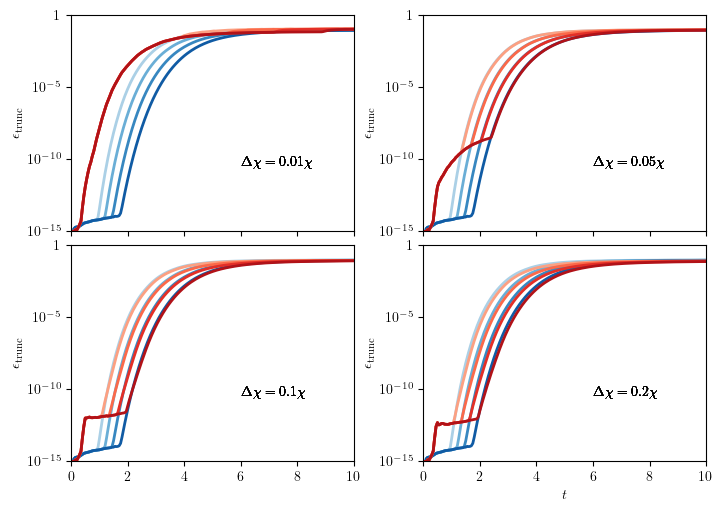

In [9]:
fig_width =  textwidth
aspect = .7
legend_fontsize = 9

plot_kwargs_map = dict(
    torch=dict(markersize=5, lw=2), #, **marker_kwargs_map['qr']
    numpy=dict(ls='-', lw=2),
)

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(fig_width, aspect * fig_width))
axs_flat = axs.reshape((4,))

for ax in axs_flat:
    ax.set_xlim((0, 10))
axs_flat[-1].set_xlabel('$t$')

for ax, cbe in zip(axs_flat, [0.01, 0.05, 0.1, 0.2]):
    for backend, truncator in [('numpy', 'svd'), ('torch', 'qr_bond')]:
        for chi in [512, 1024, 2048, 4096]:
            try:
                res = load_showcase(N=5, backend=backend, truncator=truncator, chi=chi,
                                    cbe=None if backend=='numpy' else cbe)
            except AssertionError as e:
                print(f'error ignored: {e}')
                continue
            torch_step = 1
            step = torch_step if backend == 'torch' else 1

            ax.set_ylabel(r'$\epsilon_\mathrm{trunc}$')
            ax.set_ylim(1e-15, 1)
            ax.semilogy(res['times'][1:][::step], res['trunc_err'][::step], color=get_color(backend, truncator, chi),
                            **plot_kwargs_map[backend])
            ax.set_yticks([1e-15, 1e-10, 1e-5, 1])
            ax.set_yticklabels(['$10^{-15}$', '$10^{-10}$', '$10^{-5}$', '$1$'])
            
            ax.text(0.6, 0.3, '$\Delta\chi = ' + str(cbe) + '\chi$', transform=ax.transAxes)

fig.tight_layout(pad=0.1)
plt.show()

Choose $\Delta\chi = 0.1\chi$ in the following.
Error of $\sim 10^{-12}$ is tolerable

# Production Plot 1
- Demonstrate QR GPU vs SVD CPU
- main message: same result but much faster

1902.0549030303955 -> 32m
12383.431284427643 -> 206m
85034.88406968117 -> 24h
644995.5541045666 -> 179h
21.0743145942688 -> 21s
68.91376209259033 -> 69s
350.6522400379181 -> 6m
2281.375358104706 -> 38m


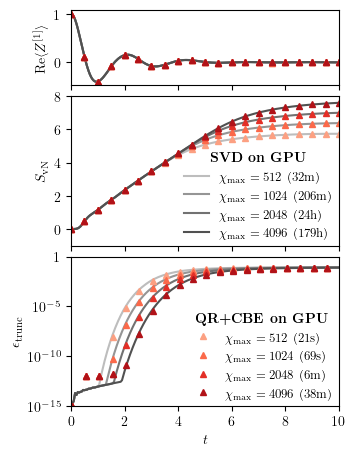

In [10]:
fig_width = .48 * textwidth
aspect = 1.3
legend_fontsize = 9

skip_svd_4096 = False  # this is a very slow datapoint. plot without it for now

N = 5
cbe = 0.1

plot_kwargs_map = dict(
    qr_bond=dict(markersize=5, lw=.5, **marker_kwargs_map['qr_bond']), 
    svd=dict(ls='-', lw=1.5),
)

fig, axs_flat = plt.subplots(3, 1, sharex=True, figsize=(fig_width, aspect * fig_width), gridspec_kw=dict(height_ratios=[1, 2, 2]))
ax_obs, ax_ent, ax_err = axs_flat

for ax in axs_flat:
    ax.set_xlim((0, 10))
axs_flat[-1].set_xlabel('$t$')

handles = dict(svd={}, qr_bond={})  # handles[truncator][chi]
backend = 'torch'

has_incomplete_data = False
for truncator in ['svd', 'qr_bond']:
    for chi in [512, 1024, 2048, 4096]:
        if skip_svd_4096 and (truncator, chi) == ('svd', 4096):
            continue
        
        res = load_showcase(N, 'torch', truncator, chi, double_precision=True, cbe=cbe if truncator == 'qr_bond' else None)
        step = 10 if truncator == 'qr_bond' else 1
        if truncator == 'svd':
            min_chi = 64
            max_chi = 16384 #32768 #8192
            assert min_chi <= chi <= max_chi
            val = np.log(chi / min_chi) / np.log(max_chi / min_chi)
            color = mpl.colormaps['Greys'](val)
        else:
            color = get_color(backend, truncator, chi)
        
        if len(res['times']) < 201:
            has_incomplete_data = True
        
        # observable
        ax_obs.set_ylabel(r'Re$\langle Z^{[1]}\rangle$')
        Z = np.array([zs[0] for zs in res['z_expvals']])
        ax_obs.plot(res['times'][::step], Z[::step], color=color, **plot_kwargs_map[truncator])
        
        # entropy
        ax_ent.set_ylabel(r'$S_\mathrm{vN}$')
        ax_ent.set_ylim(0 if skip_svd_4096 else -1, 8)
        h, = ax_ent.plot(res['times'][::step], res['entropy'][::step], color=color,
                         label=r'$\chi_{\mathrm{max}} =' + str(chi) + '$ (' + format_runtime(res["run_time"]) + ')',
                         **plot_kwargs_map[truncator])
        handles[truncator][chi] = h
        
        # trunc err
        ax_err.set_ylabel(r'$\epsilon_\mathrm{trunc}$')
        ax_err.set_ylim(1e-15, 1)
        ax_err.semilogy(res['times'][1:][::step], res['trunc_err'][::step], color=color,
                        **plot_kwargs_map[truncator])
        ax_err.set_yticks([1e-15, 1e-10, 1e-5, 1])
        ax_err.set_yticklabels(['$10^{-15}$', '$10^{-10}$', '$10^{-5}$', '$1$'])

        
if has_incomplete_data:
    ax_ent.text(.05, .6, 'Preliminary \nData!\nSVD sim\nstill running', transform=ax_ent.transAxes)
        
l1 = ax_ent.legend(
    handles=[handles['svd'][chi] for chi in sorted(handles['svd'].keys())],
    title='\\textbf{SVD on GPU}',
    frameon=False,
    bbox_to_anchor=(1, 0), loc='lower right',
    prop=dict(size=legend_fontsize),
    borderpad=0
)
#l1._legend_box.align = 'left'

l2 = ax_err.legend(
    handles=[handles['qr_bond'][chi] for chi in sorted(handles['qr_bond'].keys())],
    title='\\textbf{QR+CBE on GPU}',
    frameon=False,
    bbox_to_anchor=(1, 0), loc='lower right',
    prop=dict(size=legend_fontsize),
    borderpad=0
)
#l2._legend_box.align = 'left'
#legend = fig.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))

fig.tight_layout(pad=0.1)
fig.savefig('showcase.pdf', bbox_inches='tight')
plt.show()

## Agreement of observables

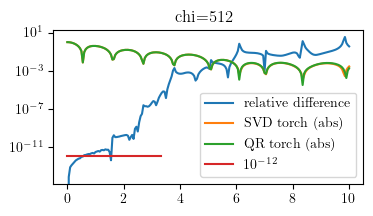

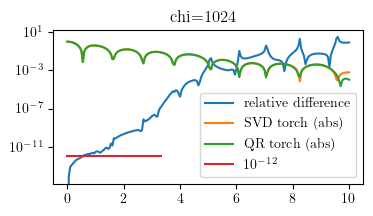

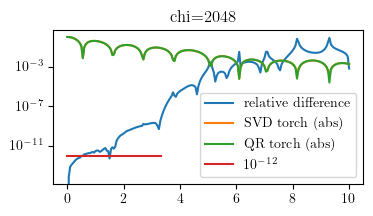

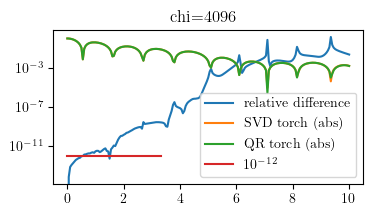

In [11]:
N = 5
cbe = 0.1

exponent = 12

for chi in [512, 1024, 2048, 4096]:
    res_np = load_showcase(N, 'torch', 'svd', chi, double_precision=True, cbe=None)
    Z_np = np.array([zs[0] for zs in res_np['z_expvals']])
    res_torch = load_showcase(N, 'torch', 'qr_bond', chi, double_precision=True, cbe=cbe)
    Z_torch = np.array([zs[0] for zs in res_torch['z_expvals']])
    t = np.array(res_torch['times']) if len(Z_torch) >= len(Z_np) else np.array(res_np['times'])
    num = min(len(Z_np), len(Z_torch))
    diff = np.abs((Z_np[:num] - Z_torch[:num]))
    
    fig, ax = plt.subplots(figsize=(4,2))
    fig.suptitle(f'chi={chi}')
    ax.semilogy(t[:num], diff / np.abs(Z_np[:num]), label='relative difference')
    ax.semilogy(t[:len(Z_np)], np.abs(Z_np), label='SVD torch (abs)')
    ax.semilogy(t[:len(Z_torch)], np.abs(Z_torch), label='QR torch (abs)')
    ax.semilogy([t[0], t[-1]/3], [10**(-exponent)] * 2, label='$10^{-' + str(exponent) + '}$')
    ax.legend(loc='best')
    plt.show()

# Production Plot 2
- Benchmark just the core of the algorithm, i.e. contract theta and decompose it
- Obtained representative MPS states from QR-based TEBD, take them at steps 100, 105, ...

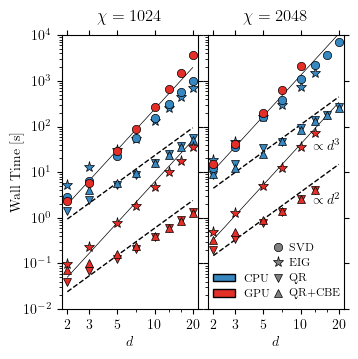

highest speedup (SVD CPU -> QR GPU) is 747.55. reached at chi=1024 and d=20
highest speedup (SVD GPU -> QR GPU) is 2705.66. reached at chi=1024 and d=20


In [12]:
fig_width = .48 * textwidth
legend_fontsize = 8
aspect = 1

all_Ns = np.array([2, 3, 5, 7, 10, 13, 16, 20])
chis = [1024, 2048]
all_hardware = ['numpy', 'torch']  #['cpu', 'a100', 'rtx']

eye_guide_kwargs = {
    2: dict(ls='--', lw=1, color='black'),
    3: dict(ls='-', lw=.5, color='black'),
}

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(fig_width, aspect * fig_width))

data = {}  # data[chi, hardware, truncator] = Ns, runtimes
for ax, chi in zip([ax1, ax2], chis):
    ax.set_title('$\\chi=' + str(chi) + '$', y=1.02)
    for hardware in all_hardware:
        for truncator in ['qr', 'qr_bond', 'eig', 'svd']:
            Ns = []
            runtimes = []
            for N in all_Ns:
                try:
                    res = load_benchmark_times(truncator, hardware, N, chi)
                except Exception as e:
                    continue
                Ns.append(N)
                runtimes.append(np.average(res))
            Ns = np.array(Ns)
            runtimes = np.array(runtimes)
            data[chi, hardware, truncator] = Ns, runtimes
            
            ax.loglog(Ns, runtimes, color=get_color(hardware, truncator, 2048),
                      **marker_kwargs_map[truncator], markeredgewidth=.5, markeredgecolor='black')
            

# eye guides with scaling d^2 and d^3
eye_guide_kwargs = {
    2: dict(ls='--', lw=1, color='black'),
    3: dict(ls='-', lw=.5, color='black'),
}       
        
def plot_eye_guide(which, ax, chi, exponent):
    prefactors = []
    for backend, truncator in which:
        Ns, ts = data[chi, backend, truncator]
        prefactors += list(ts / (Ns ** exponent))
    prefactor = np.average(prefactors)
    ax.loglog(all_Ns, prefactor * (all_Ns ** exponent), **eye_guide_kwargs[exponent], zorder=1.5)

for ax, chi in zip([ax1, ax2], chis):
    plot_eye_guide([('torch', 'qr'), ('torch', 'qr_bond')], ax, chi, 2)
    plot_eye_guide([('torch', 'eig')], ax, chi, 3)
    plot_eye_guide([('numpy', 'qr'), ('numpy', 'qr_bond')], ax, chi, 2)
    plot_eye_guide([('numpy', 'eig'), ('numpy', 'svd'), ('torch', 'svd')], ax, chi, 3)
ax2.text(12.5, 2, r'$\propto d^2$', color=eye_guide_kwargs[2]['color'])
ax2.text(12.5, 30, r'$\propto d^3$', color=eye_guide_kwargs[3]['color'])


# axes setup: 
for ax in (ax1, ax2):
    #  limits
    ax.set_xlim(1.8, 22)
    ax.set_ylim(1e-2, 1e4)
    #ax.set_ylim(.0005, 2000)
    
    #  ticks
    ax.set_xscale("log", subs=list(range(1, 11)))
    ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_xticks([2, 3, 5, 10, 20])
    ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator(all_Ns))
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=ax is ax1, labelright=False,
                   bottom=True, left=True, right=True, top=True)
    #if ax in [ax1, ax2]:
    #    ax.set_yticks([1e-3, 1e-2, 1e-1, 1, 10, 100])
    #else:
    #    ax.set_yticks([1e-1, 1, 10, 100, 1e3, 1e4])
    
    #  labels
    ax.set_xlabel('$d$')
    if ax is ax1:
        ax.set_ylabel('Wall Time [s]')
    
# choose legend style. this will be used as kwargs for ax.legend
legend_style = dict(
    borderless=[
        dict(loc='lower right', bbox_to_anchor=(1.6, 0), framealpha=0, frameon=False),
        dict(loc='lower right', bbox_to_anchor=(1.05, 0), framealpha=0, frameon=False),
    ],
    overlapping=[
        dict(loc='lower right', bbox_to_anchor=(1.45, 0), framealpha=1),
        dict(loc='lower right', bbox_to_anchor=(1, 0), framealpha=1),
    ],
    in_axes=[
        dict(loc='lower right', bbox_to_anchor=(1, 0), framealpha=1),
        dict(loc='lower right', bbox_to_anchor=(1, 0), framealpha=1),
    ],
    colors_upper=[
        dict(loc='upper left', bbox_to_anchor=(0, 1), framealpha=1),
        dict(loc='lower right', bbox_to_anchor=(1, 0), framealpha=1),
    ]
)['borderless']


# first legend: colors are CPU / GPU
from matplotlib.patches import Patch
cpu_handle = Patch(facecolor=get_color('numpy', 'svd', 2048), edgecolor='black', label='CPU')
gpu_handle = Patch(facecolor=get_color('torch', 'svd', 2048), edgecolor='black', label='GPU')
l = ax1.legend(handles=[cpu_handle, gpu_handle], prop=dict(size=legend_fontsize), **legend_style[0])
l.remove()
ax2.add_artist(l)

# second legend: markers represent truncation schemes
ax = ax2
svd_handle, = ax.plot([], [], color='gray', **marker_kwargs_map['svd'], markeredgewidth=.5, markeredgecolor='black', label='SVD')
eig_handle, = ax.plot([], [], color='gray', **marker_kwargs_map['eig'], markeredgewidth=.5, markeredgecolor='black', label='EIG')
qr_handle, = ax.plot([], [], color='gray', **marker_kwargs_map['qr'], markeredgewidth=.5, markeredgecolor='black', label='QR')
qr_bond_handle, = ax.plot([], [], color='gray', **marker_kwargs_map['qr_bond'], markeredgewidth=.5, markeredgecolor='black', label=r'QR+CBE')
l = ax.legend(handles=[svd_handle, eig_handle, qr_handle, qr_bond_handle], prop=dict(size=legend_fontsize), 
              handletextpad=0, columnspacing=.3, **legend_style[1])
#l.remove()
#ax2.add_artist(l)

    
ax1.yaxis.labelpad = 0
fig.tight_layout(pad=0)
fig.savefig('timing_benchmark.pdf', bbox_inches='tight')
plt.show()

# greatest speedups
for backend1 in ['numpy', 'torch']:

    chis = [1024, 2048]
    all_Ns = np.array([2, 3, 5, 7, 10, 13, 16, 20])
    best = 0
    best_chi = None
    best_N = None

    for chi in chis:
        N1, t1 = data[chi, backend1, 'svd']
        N2, t2 = data[chi, 'torch', 'qr']
        for N in all_Ns:
            if N not in N1 or N not in N2:
                continue
            speedup = t1[list(N1).index(N)] / t2[list(N2).index(N)]
            if speedup > best:
                best = speedup
                best_chi = chi
                best_N = N

    print(f'highest speedup (SVD {dict(numpy="CPU", torch="GPU")[backend1]} -> QR GPU) is {best:.2f}. reached at chi={best_chi} and d={best_N}')

# Check dependence of run time in number of cores
- we claim runtimes on 64 core CPU, so we should check that the code can actually use them

error ignored: file does not exist: ../data/num_threads_benchmark/svd_numpy_5_2048_2.txt
error ignored: file does not exist: ../data/num_threads_benchmark/svd_numpy_5_2048_4.txt
error ignored: file does not exist: ../data/num_threads_benchmark/svd_numpy_5_4096_1.txt
error ignored: file does not exist: ../data/num_threads_benchmark/svd_numpy_5_4096_2.txt
error ignored: file does not exist: ../data/num_threads_benchmark/svd_numpy_5_4096_4.txt
error ignored: file does not exist: ../data/num_threads_benchmark/svd_numpy_5_4096_16.txt


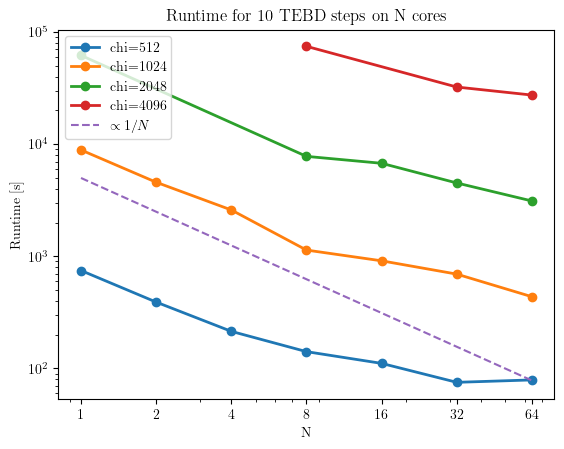

In [13]:
fig, ax = plt.subplots()

ax.set_title('Runtime for 10 TEBD steps on N cores')
ax.set_ylabel('Runtime [s]')
ax.set_xlabel('N')

for chi in [512, 1024, 2048, 4096]:
    Ns = []
    ts = []
    for N in [1, 2, 4, 8, 16, 32, 64]:
        try:
            t = load_num_threads_time('svd', 'numpy', 5, chi, N)
        except AssertionError as e:
            print(f'error ignored: {e}')
            continue
        Ns.append(N)
        ts.append(t)
    Ns = np.array(Ns)
    ts = np.array(ts)
    if len(Ns) == 0:
        continue
    ax.loglog(Ns, ts, 'o-', lw=2, label=f'chi={chi}')

    
tick_Ns = np.array([1, 2, 4, 8, 16, 32, 64])
ax.loglog(tick_Ns, 5e3 / tick_Ns , '--', label=r'$\propto 1/N$')

ax.set_xticks(tick_Ns)
#ax.set_xticklabels([r'$\frac{1}{' + str(N) + '}$' for N in tick_Ns])
ax.set_xticklabels([r'${' + str(N) + '}$' for N in tick_Ns])


ax.legend()
plt.show()

# Sanity check: Compare runtime of my toycode to tenpy
This is to make sure i did not make any stupid mistakes in my TEBD implementation, that distort the runtimes

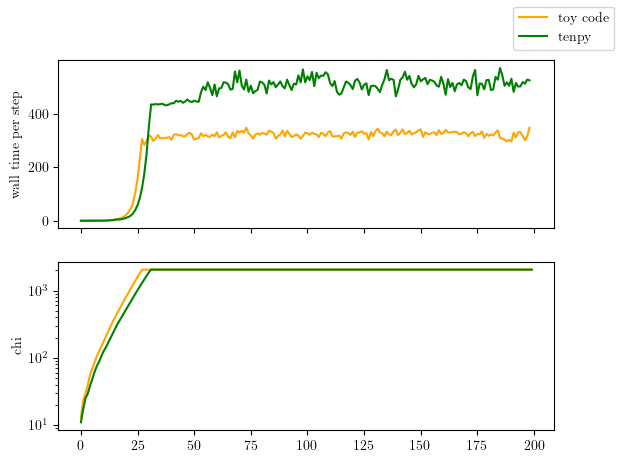

In [15]:
N = 5
chi = 2048

def read_chis_from_log(file, num_headers=14, step=2):
    with open(file, 'r') as f:
        lines = f.readlines()
    lines = lines[num_headers:]
    lines = lines[::step]
    chis = []
    for l in lines:
        _, l = l.split('chi=')
        chi, _ = l.split(', S_vN=')
        chis.append(int(chi))
    return chis

tenpy_log_file = Path('../data').expanduser().joinpath(f'L_2_g_2_dt_0.05/tenpy/N_{N}/chi_{chi}/simulation.log')
tenpy_chis = np.array(read_chis_from_log(tenpy_log_file, num_headers=14, step=2))

toy_log_file = Path('../data').expanduser().joinpath(f'L_2_g_2_dt_0.05/svd_numpy/N_{N}/chi_{chi}_eval_1/simulation.log')
toy_chis = np.array(read_chis_from_log(toy_log_file, num_headers=4, step=1))

toy_data = load_showcase(N, 'numpy', 'svd', chi, double_precision=True, cbe=None)
toy_runtimes = np.array(toy_data['run_times'])
toy_steptimes = toy_runtimes[1:] - toy_runtimes[:-1]

tenpy_data = load_showcase(N, 'tenpy', 'svd', chi, double_precision=True, cbe=None)
tenpy_runtimes = np.array(tenpy_data['run_times'])
tenpy_steptimes = tenpy_runtimes[1:] - tenpy_runtimes[:-1]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(toy_steptimes, color='orange', label='toy code')
ax1.plot(tenpy_steptimes, color='green', label='tenpy')
ax1.set_ylabel('wall time per step')

ax2.semilogy(toy_chis, color='orange')
ax2.semilogy(tenpy_chis, color='green')
ax2.set_ylabel('chi')

fig.legend()

plt.show()